In [1]:
import glob
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.interpolate import interp1d
from scipy.stats.stats import pearsonr   
import itertools as it
import Colors
from neupy import algorithms
import venn

In [2]:
from neupy import algorithms
import statsmodels.stats.multitest as multi

In [3]:
import lmfit

In [4]:
from scipy.signal import savgol_filter

# read data

In [5]:
files = glob.glob('../E85*coutt.tsv')
files

['../E85_exp1.coutt.tsv',
 '../E85_exp1_norm.coutt.tsv',
 '../E85_exp2.coutt.tsv',
 '../E85_exp2_norm.coutt.tsv',
 '../E85_exp3.coutt.tsv',
 '../E85_exp3_norm.coutt.tsv']

In [6]:
files = ['../E85_exp1.coutt.tsv', '../E85_exp2.coutt.tsv', '../E85_exp3.coutt.tsv']

In [7]:
titles = ['E8.5, rep1', 'E8.5, rep2', 'E8.5, rep3']

In [8]:
dfs = [read_csv(f, sep = '\t', index_col=0) for f in files]

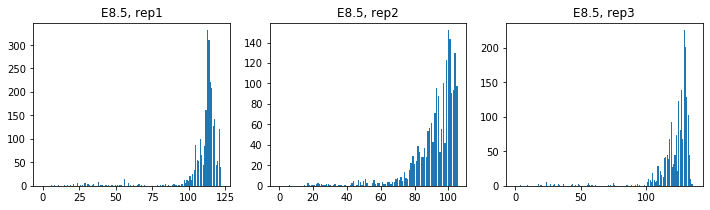

In [9]:
g = [idx for idx in dfs[0].index if 'T_' in idx][0]
plt.figure(figsize=(4*len(dfs),3))
for i, df in enumerate(dfs):
    plt.subplot(1,len(dfs), i+1)
    plt.bar(range(len(df.columns)), df.loc[g]); plt.title(titles[i])
plt.show()

In [10]:
dfs[0].columns = ['E85r1-' + c for c in dfs[0].columns]
dfs[1].columns = ['E85r2-' + c for c in dfs[1].columns]
dfs[2].columns = ['E85r3-' + c for c in dfs[2].columns]

# remove genes

In [11]:
def removeGenes(df):
    genes = ['ERCC','chrM', 'Kcnq1ot1', 'Mir5109', 'Lars2','Malat1', 'Rn45s', 'Rpl', 'Rps','__MT']
    exclude = [idx for idx in df.index for g in genes if g in idx]
    return df.loc[[idx for idx in df.index if idx not in exclude]]

# def removeGmGenes(df):
#     g = []
#     for idx in df.index:
#         if 'Gm' in idx:
#             gid = idx.rsplit('Gm')[1].rsplit('__')[0]
#             if sum([n in [str(r) for r in range(10)] for n in gid]) == len(gid):
#                 g.append(idx)
#     return df.loc[[idx for idx in df.index if idx not in g]]

In [12]:
#fdfs = [removeGmGenes(removeGenes(df)) for df in dfs]
fdfs = [removeGenes(df) for df in dfs]

In [13]:
fdfs = [df.loc[df.index[df.sum(axis=1)>0]] for df in fdfs]

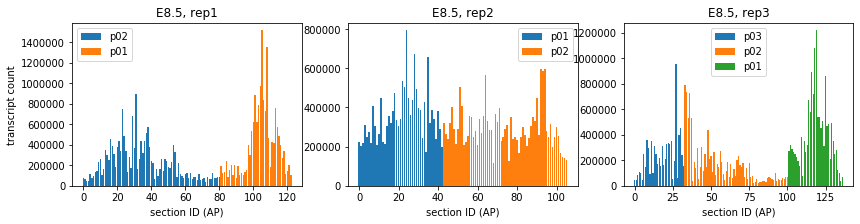

In [14]:
plt.figure(figsize=(14,3))

for i, df in enumerate(fdfs):
    plt.subplot(1,len(fdfs),i+1)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.bar(range(x0,x0+len(cols)), df[cols].sum(), label = plate)
        x0 += len(cols)
    plt.legend()
    plt.title(titles[i])
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')
plt.show()

# Gene-specific batch effect correction

In [15]:
def rescale(df, n = 5):
    rdf = df.copy()
    x = [c.rsplit('-')[-1] for c in df.index]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    for i in range(len(plates)-1):
        c0 = [c for c in df.index if plates[i] in c]
        c1 = [c for c in df.index if plates[i+1] in c]
        sc0 = c0[-n:]
        sc1 = c1[:n]
        if rdf[sc1].mean() != 0:
            beta = rdf[sc0].mean()/rdf[sc1].mean()
        else:
            beta = 1
        rdf[c1] *= beta
    return rdf

In [16]:
g = 'Uncx'

In [17]:
fg = [idx for idx in fdfs[0].index if g in idx][0]
print(fg)

ENSMUSG00000029546_Uncx__protein_coding__5


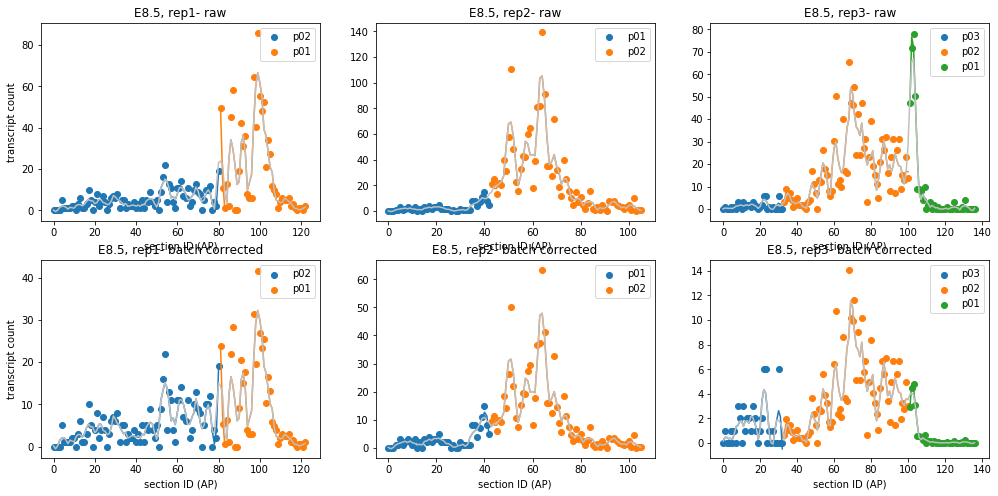

In [18]:
plt.figure(figsize=(17,8))

for i, df in enumerate(fdfs):
    plt.subplot(2,len(fdfs),i+1)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.scatter(range(x0,x0+len(cols)), df.loc[fg,cols], label = plate)
        plt.plot(range(x0,x0+len(cols)), savgol_filter(df.loc[fg,cols], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_')

        x0 += len(cols)
    plt.plot(range(len(df.columns)), savgol_filter(df.loc[fg], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_', c = 'silver')
    plt.legend()
    plt.title(titles[i] + '- raw')
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')
    
    plt.subplot(2,len(fdfs),i+1+len(fdfs))
    kdf = rescale(df.loc[fg]) # rescale(kdf)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.scatter(range(x0,x0+len(cols)), kdf[cols], label = plate)
        plt.plot(range(x0,x0+len(cols)), savgol_filter(kdf[cols], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_')

        x0 += len(cols)
    plt.plot(range(len(kdf.index)), savgol_filter(kdf, window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_', c = 'silver')
    plt.legend()
    plt.title(titles[i] + '- batch corrected')
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')
#plt.savefig('../results/batchCorrection/uncx_batch.pdf', bbox_inches = 'tight')
plt.show()

ENSMUSG00000013584_Aldh1a2__protein_coding__9


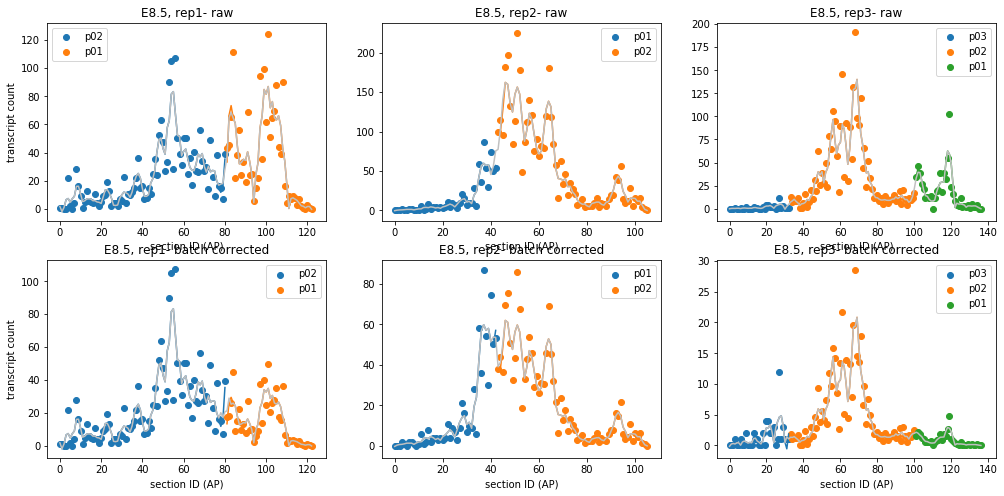

In [19]:
g = '_Aldh1a2_'

fg = [idx for idx in fdfs[0].index if g in idx][0]
print(fg)

plt.figure(figsize=(17,8))

for i, df in enumerate(fdfs):
    plt.subplot(2,len(fdfs),i+1)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.scatter(range(x0,x0+len(cols)), df.loc[fg,cols], label = plate)
        plt.plot(range(x0,x0+len(cols)), savgol_filter(df.loc[fg,cols], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_')

        x0 += len(cols)
    plt.plot(range(len(df.columns)), savgol_filter(df.loc[fg], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_', c = 'silver')
    plt.legend()
    plt.title(titles[i] + '- raw')
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')
    
    plt.subplot(2,len(fdfs),i+1+len(fdfs))
    kdf = rescale(df.loc[fg]) # rescale(kdf)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.scatter(range(x0,x0+len(cols)), kdf[cols], label = plate)
        plt.plot(range(x0,x0+len(cols)), savgol_filter(kdf[cols], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_')

        x0 += len(cols)
    plt.plot(range(len(kdf.index)), savgol_filter(kdf, window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_', c = 'silver')
    plt.legend()
    plt.title(titles[i] + '- batch corrected')
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')

#plt.savefig('../results/batchCorrection/aldh1a2_batch.pdf', bbox_inches = 'tight')
plt.show()

ENSMUSG00000062327_T__protein_coding__17


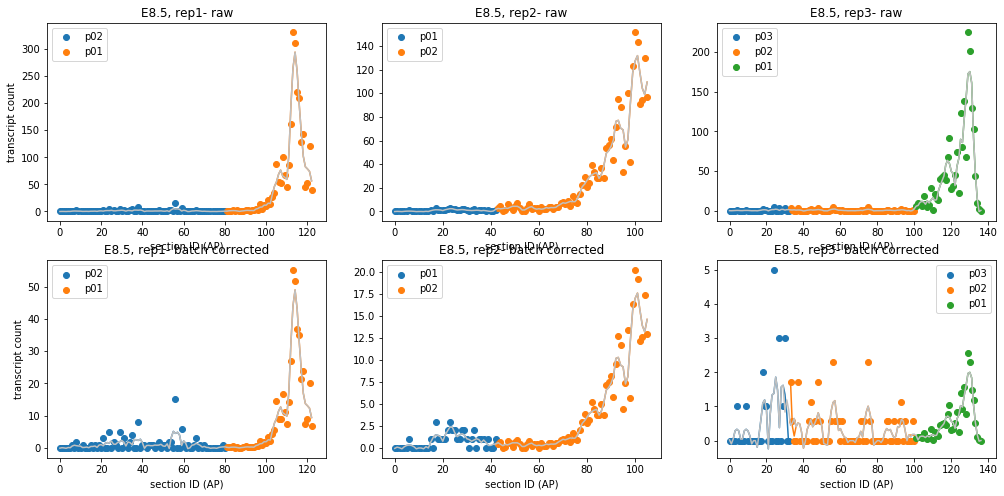

In [20]:
g = '_T_'

fg = [idx for idx in fdfs[0].index if g in idx][0]
print(fg)

plt.figure(figsize=(17,8))

for i, df in enumerate(fdfs):
    plt.subplot(2,len(fdfs),i+1)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.scatter(range(x0,x0+len(cols)), df.loc[fg,cols], label = plate)
        plt.plot(range(x0,x0+len(cols)), savgol_filter(df.loc[fg,cols], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_')

        x0 += len(cols)
    plt.plot(range(len(df.columns)), savgol_filter(df.loc[fg], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_', c = 'silver')
    plt.legend()
    plt.title(titles[i] + '- raw')
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')
    
    plt.subplot(2,len(fdfs),i+1+len(fdfs))
    kdf = rescale(df.loc[fg]) # rescale(kdf)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.scatter(range(x0,x0+len(cols)), kdf[cols], label = plate)
        plt.plot(range(x0,x0+len(cols)), savgol_filter(kdf[cols], window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_')

        x0 += len(cols)
    plt.plot(range(len(kdf.index)), savgol_filter(kdf, window_length = 7, polyorder = 3, deriv = 0), label = '_nolabel_', c = 'silver')
    plt.legend()
    plt.title(titles[i] + '- batch corrected')
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')

#plt.savefig('../results/batchCorrection/T_batch.pdf', bbox_inches = 'tight')
plt.show()

In [21]:
rfdfs = []
for df in fdfs:
    rdf = df.copy()
    for idx in rdf.index:
        rdf.loc[idx] = rescale(rdf.loc[idx])
    rfdfs.append(rdf)

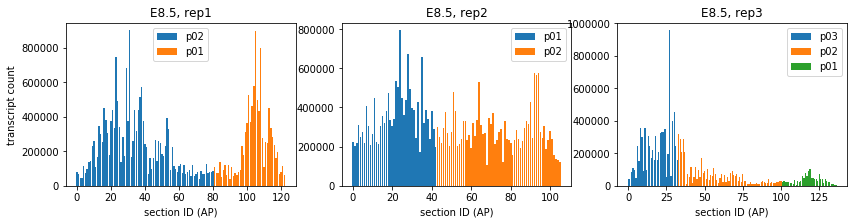

In [22]:
plt.figure(figsize=(14,3))

for i, df in enumerate(rfdfs):
    plt.subplot(1,len(fdfs),i+1)
    x = [c.rsplit('-')[-1] for c in df.columns]
    plates = []; p0 = 'p00'
    for j in range(len(x)):
        if x[j] != p0:
            p0 = x[j] 
            plates.append(p0)
    x0 = 0
    for plate in plates:
        cols = [c for c in df.columns if c.rsplit('-')[-1]==plate]
        plt.bar(range(x0,x0+len(cols)), df[cols].sum(), label = plate)
        x0 += len(cols)
    plt.legend()
    plt.title(titles[i])
    
    plt.xlabel('section ID (AP)')
    if i == 0:
        plt.ylabel('transcript count')
#plt.savefig('../results/batchCorrection/totalTranscript_postBatch.pdf', bbox_inches = 'tight')
plt.show()

# normalization

In [23]:
nfdfs = [df.sum().mean()*df/df.sum() for df in rfdfs]

In [24]:
names = ['E85_rep1','E85_rep2','E85_rep3']
for i in range(len(nfdfs)):
    nfdfs[i].to_csv('../' + names[i] + '_unbatch_norm.coutt.tsv', sep = '\t')
    rfdfs[i].to_csv('../' + names[i] + '_unbatch_raw.coutt.tsv', sep = '\t')

# z-scores

In [25]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

In [26]:
znfdfs = [zscore(df) for df in nfdfs]
sznfdfs = [scalezscore(df) for df in znfdfs]

# gene selection based on correlation

In [27]:
def simulationCorrelations(n1, n2, N = 5000):
    x1 = np.linspace(0,1,n1)
    x2 = np.linspace(0,1,n2)
    ps = [0 for i in range(N)]
    for i in range(N):
        d1 = np.random.rand(n1)
        d2 = np.random.rand(n2)

        id2 = interp1d(x2, d2, kind='quadratic')
        ps[i] = pearsonr(d1, id2(x1))[0]
    psdf = pd.DataFrame({'corr': sorted(ps), 'cum': np.linspace(0,1, N)})
    psdf['pval'] = 1.-psdf['cum']
    return psdf

In [28]:
## Correlation between genes

def geneCorrelation(df1, df2):
    x1 = 1.0*np.arange(len(df1.columns))/(len(df1.columns)-1)
    x2 = 1.0*np.arange(len(df2.columns))/(len(df2.columns)-1)
    cnt = Counter(list(df1.index) + list(df2.index))
    genes = [g for g in cnt if cnt[g] == 2]
    
    cdf = pd.Series(0, index = genes)
    for g in genes:
        idf2 = interp1d(x2, df2.loc[g].values, kind='quadratic')
        cdf.loc[g] = pearsonr(df1.loc[g], idf2(x1))[0]
    return cdf

def assignPval2corr(cdf, pdf, corrcolname = 'corr'):
    cdf2 = pd.DataFrame(cdf, columns = [corrcolname])
    cdf2['pv'] = 0
    for g in cdf.index:
        pv = cdf.loc[g]
        if (pdf['corr'] >= pv).sum() > 0:
            p0 = pdf[pdf['corr'] >= pv].iloc[0]['pval']
        else:
            p0 = 0.
        if (pdf['corr'] <pv).sum() > 0:
            p1 = pdf[pdf['corr'] < pv].iloc[-1]['pval']
        else:
            p1 = 1.
        cdf2.loc[g,'pv'] = 0.5*(p0+p1)
    cdf2['adj-pv'] = multi.fdrcorrection(cdf2['pv'],  method='indep')[1]
    return cdf2  

In [29]:
def mergeGeneLists(gene_list):
    for x in gene_list:
        gene_list[x].columns = [str(c) + '_' + str(x) for c in gene_list[x].columns]
    ks = list(gene_list.keys())
    mdf = gene_list[ks[0]]
    for i in range(1,len(ks)):
        mdf = mdf.merge(gene_list[ks[i]], how = 'inner', left_index = True, right_index = True)
    return mdf

In [30]:
pv_sim = {}
corrGenes = {}
for x, (i1, i2) in enumerate(it.combinations(range(len(znfdfs)), 2)):
    pv_sim[(i1, i2)] = simulationCorrelations(n1 = len(znfdfs[i1].columns), n2 = len(znfdfs[i2].columns))
    corrGenes[(i1, i2)] = geneCorrelation(znfdfs[i1], znfdfs[i2])
    corrGenes[(i1, i2)] = assignPval2corr(corrGenes[(i1, i2)], pv_sim[(i1,i2)])
#mdf5d = mergeGeneLists(corrGenes_5d)
#mdf5d.head(10)

In [31]:
corrGenes_df = mergeGeneLists(corrGenes)

In [32]:
#corrGenes_df.to_csv('../results/batchCorrection/gene_correlations.tsv', sep = '\t')

In [33]:
pvth = 0.1; nth = 3
pvcols = [c for c in corrGenes_df.columns if 'pv_('==c[:4]]
corrgenes = corrGenes_df.index[corrGenes_df.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [34]:
len(corrgenes), 5*np.sqrt(len(corrgenes))

(1440, 189.73665961010278)

# clustering

In [37]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [38]:
def mergedfs(dfs):
    mdf = dfs[0]
    for df in dfs[1:]:
        mdf = mdf.merge(df, how = 'outer', left_index = True, right_index = True)
        mdf = mdf.fillna(0)
    return mdf

In [39]:
mznfdfs = mergedfs(znfdfs)
msznfdfs = mergedfs(sznfdfs)

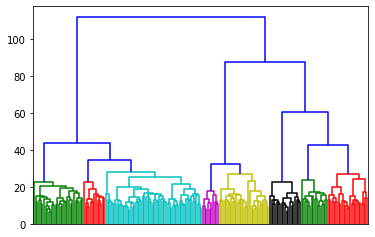

In [40]:
np.random.seed = 172361
somhcl_df = comboCluster(mznfdfs, corrgenes, cth = 30, gridheight = 10, gridwidth = 20 )

In [42]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2',
          'Mesp2','Ripply2','Dppa5a','Gata6','Meox1','Tbx6','T']

In [44]:
for g in g_annotate:
    print(g, [idx for idx in mznfdfs.index if '_' + g + '__' in idx])

annotate = []
for g in g_annotate:
    gs = [idx for idx in msznfdfs.index if '_' + g + '__' in idx]
    if len(gs) == 1:
        annotate.append(gs[0])

Cdx2 ['ENSMUSG00000029646_Cdx2__protein_coding__5']
Rspo3 ['ENSMUSG00000019880_Rspo3__protein_coding__10']
Sox1 ['ENSMUSG00000096014_Sox1__protein_coding__8']
Sox2 ['ENSMUSG00000074637_Sox2__protein_coding__3']
Wnt3a ['ENSMUSG00000009900_Wnt3a__protein_coding__11']
Fgf8 ['ENSMUSG00000025219_Fgf8__protein_coding__19']
Uncx ['ENSMUSG00000029546_Uncx__protein_coding__5']
Aldh1a2 ['ENSMUSG00000013584_Aldh1a2__protein_coding__9']
Mesp2 ['ENSMUSG00000030543_Mesp2__protein_coding__7']
Ripply2 ['ENSMUSG00000047897_Ripply2__protein_coding__9']
Dppa5a ['ENSMUSG00000060461_Dppa5a__protein_coding__9']
Gata6 ['ENSMUSG00000005836_Gata6__protein_coding__18']
Meox1 ['ENSMUSG00000001493_Meox1__protein_coding__11']
Tbx6 ['ENSMUSG00000030699_Tbx6__protein_coding__7']
T ['ENSMUSG00000062327_T__protein_coding__17']


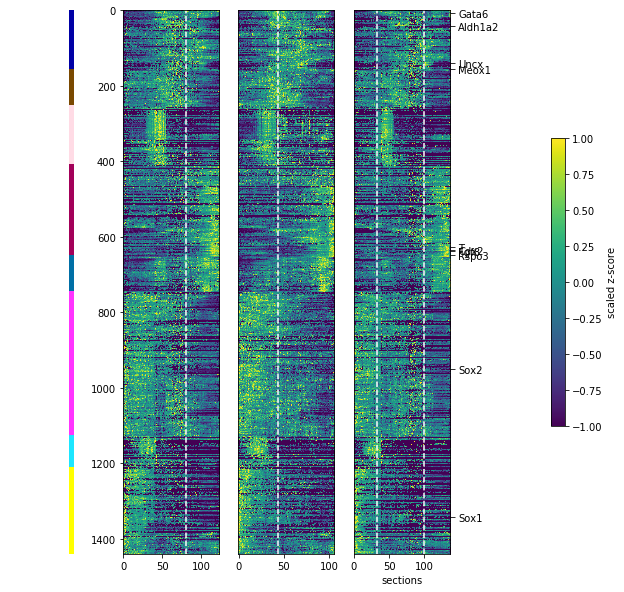

In [45]:
plt.figure(figsize=(10,10))

genes = somhcl_df.sort_values(['hcl','som']).index[::-1]
N = len(nfdfs)+2

plt.subplot(1,N,1, frameon = False)

y0 = 0
for i in set(somhcl_df['hcl']):
    y = 1.0*(somhcl_df[somhcl_df['hcl'] == i].shape[0]+1)/(somhcl_df.shape[0]+1)
    plt.bar([4], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y  
DeltaY = y0/len(genes)
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(0,6)

for i, df in enumerate(sznfdfs):
    plt.subplot(1,N,i+2)
    plt.imshow(df.loc[genes], aspect = 'auto', rasterized = True)
    if i != 0:
        plt.yticks([])
    if i==2:
        plt.xlabel('sections')
    if i == len(sznfdfs)-1:
        plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
        plt.yticks([i for i, g in enumerate(genes) if g in annotate], [g.rsplit('__')[0].rsplit('_')[-1] for g in genes if g in annotate])

    p0 = df.columns[0].rsplit('-')[-1]
    i = 0
    for c in df.columns:
        if p0 in c:
            i += 1
        else:
            p0 = c.rsplit('-')[-1]
            plt.axvline(i, c = 'w', ls = '--')
            
plt.subplot(1, N,N, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#plt.savefig('../results/batchCorrection/heatmaps_somhcl_E85_correlated_wl.pdf', bbox_inches = 'tight')

plt.show()

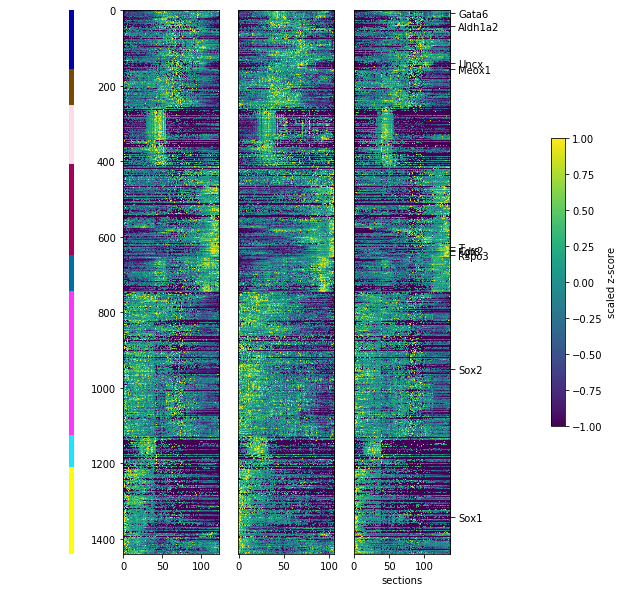

In [46]:
plt.figure(figsize=(10,10))

genes = somhcl_df.sort_values(['hcl','som']).index[::-1]
N = len(nfdfs)+2

plt.subplot(1,N,1, frameon = False)

y0 = 0
for i in set(somhcl_df['hcl']):
    y = 1.0*(somhcl_df[somhcl_df['hcl'] == i].shape[0]+1)/(somhcl_df.shape[0]+1)
    plt.bar([4], [y], bottom = y0, width = 0.3, color = Colors.colors[i])
    y0 += y  
DeltaY = y0/len(genes)
plt.yticks([]); plt.xticks([])
plt.ylim(0,1)
plt.xlim(0,6)

for i, df in enumerate(sznfdfs):
    plt.subplot(1,N,i+2)
    plt.imshow(df.loc[genes], aspect = 'auto', rasterized = True)
    if i != 0:
        plt.yticks([])
    if i==2:
        plt.xlabel('sections')
    if i == len(sznfdfs)-1:
        plt.tick_params(axis='y', labelleft=False, labelright=True, length = 5, left = False, right = True)
        plt.yticks([i for i, g in enumerate(genes) if g in annotate], [g.rsplit('__')[0].rsplit('_')[-1] for g in genes if g in annotate])
            
plt.subplot(1, N,N, frameon = False)
plt.xticks([]); plt.yticks([])
plt.colorbar(label = 'scaled z-score')

#somhcl_df.sort_values(['hcl','som']).to_csv('../results/batchCorrection/geneClusters_somhcl_E85_correlated.txt', sep = '\t')
#plt.savefig('../results/batchCorrection/heatmaps_somhcl_E85_correlated.pdf', bbox_inches = 'tight')

plt.show()

In [47]:
for hcl in set(somhcl_df['hcl']):
    gs = list(somhcl_df[somhcl_df['hcl']==hcl].index)
    gs = sorted([g.rsplit('_')[1] for g in gs])
    print(str(hcl) + ' & ' + ', '.join(gs) + '\\\\')

0 & 0610010K14Rik, 1810041L15Rik, 2510009E07Rik, 4930426D05Rik, A730017C20Rik, Abcc4, Acly, Adcyap1r1, Adgrb1, Adgrg1, Adgrv1, Ago1, Ano1, Arl5c, Ascl1, Astn1, Btbd3, C130021I20Rik, Cachd1, Cacna1g, Cacng4, Cbln1, Ccdc160, Ccnd1, Cdc25b, Cdh11, Cdh4, Cdon, Cecr2, Celsr1, Celsr2, Celsr3, Chrna4, Chst10, Chst2, Cldn10, Clybl, Cnih2, Cnn3, Cnpy1, Cntfr, Cntnap2, Cpne5, Csmd2, Cx3cl1, D030055H07Rik, Dhx32, Dmbx1, Dmtn, Dtx4, E230020D15Rik, Efna2, Efnb1, Efnb3, Ehbp1, Elavl2, Elavl3, Elavl4, Elmod1, Eml5, Emp1, En1, En2, Epb41l4a, Ephb1, Fads1, Fads2, Fam167a, Fam181b, Fam214b, Fam84b, Fbxl16, Fbxo41, Flrt1, Foxl2, Frem2, Frzb, Fsd1l, Fut9, Fzd3, G3bp1, Garem2, Gas2l3, Gli3, Gm20083, Gm21988, Gm2694, Gm43527, Gm48898, Gnai2, Gnaz, Gnb2, Golm1, Gpr153, Gstm5, H2-K1, Herpud2, Hes3, Hist2h3b, Hmgcs1, Hs3st1, Id1, Id3, Igdcc3, Ildr2, Irx1, Irx2, Irx3, Irx5, Jam2, Jarid2, Kcnb1, Kcnj3, Kcnq3, Kif1a, Lamc3, Lfng, Lgi1, Lix1, Lmx1b, Lpar4, Manf, Map2, Map6, Map7, Mapk10, Mapk8ip1, Mapre2, Mapt, Ma

# Interesting gene patterns

## Uncx

In [48]:
Uncx = [g for g in nfdfs[0].index if 'Uncx' in g][0]
Uncx

'ENSMUSG00000029546_Uncx__protein_coding__5'

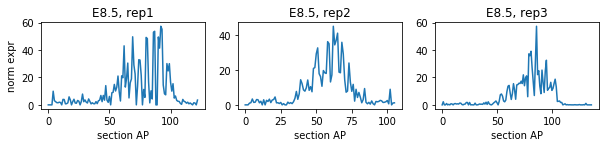

In [49]:
plt.figure(figsize=(10,3.5))
titles = ['E8.5, rep1', 'E8.5, rep2', 'E8.5, rep3']
for i, df in enumerate(nfdfs):
    plt.subplot(2,len(nfdfs),i+1)
    plt.plot(range(len(df.columns)), df.loc[Uncx], label = 'plate 2')
    plt.title(titles[i])
    plt.xlabel('section AP')
    if i == 0:
        plt.ylabel('norm expr')
#plt.savefig('../results/batchCorrection/mouse_UncxExpression.pdf', bbox_inches = 'tight')
plt.show()

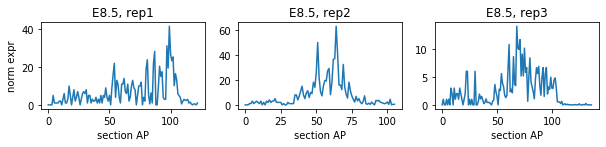

In [50]:
plt.figure(figsize=(10,3.5))
titles = ['E8.5, rep1', 'E8.5, rep2', 'E8.5, rep3']

for i, df in enumerate(rfdfs):
    plt.subplot(2,len(rfdfs),i+1)
    plt.plot(range(len(df.columns)), df.loc[Uncx], label = 'plate 2')
    plt.title(titles[i])
    plt.xlabel('section AP')
    if i == 0:
        plt.ylabel('norm expr')

plt.show()

## Gata6

In [51]:
Uncx = [g for g in nfdfs[0].index if 'Gata6' in g][0]
Uncx

'ENSMUSG00000005836_Gata6__protein_coding__18'

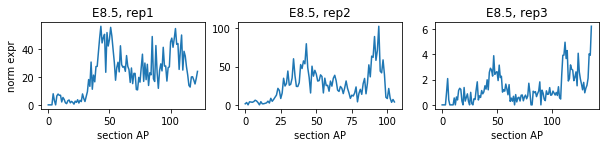

In [52]:
plt.figure(figsize=(10,3.5))
titles = ['E8.5, rep1', 'E8.5, rep2', 'E8.5, rep3']
for i, df in enumerate(nfdfs):
    plt.subplot(2,len(nfdfs),i+1)
    plt.plot(range(len(df.columns)), df.loc[Uncx], label = 'plate 2')
    plt.title(titles[i])
    plt.xlabel('section AP')
    if i == 0:
        plt.ylabel('norm expr')
plt.show()